## 0. 今日の量子コンピュータの問題

- Noisy Intermediate-Scale Quantum (NISQ) デバイス
    - 量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなる
    - 十分な量子ビット数ではない
- 量子デバイスは特別なゲート演算のみが用意されている
- 特定のqubits間の量子ビット演算(multi qubit operation)しか用意されていない
- それぞれの量子デバイスに対して、量子ソフトウェアツールキットが用意されてる


### 0-1. TKETとは
- Quantum Software Development Kit
- C++で実装
- pythonモジュール　`pytket`で利用可能
- 最適化コンパイラ：　ユーザーフレンドリーな回路→量子デバイスで実行可能な回路に変換可能
    - Language-agnostic (多くの量子プログラミングフレームワーク(qiskit, Cirq, etc)をサポート)
    - Retagetable (多くの量子デバイス(IBM, Honeywell, etc)をサポート)
    - Circuit Optimisation (量子計算時に生じるデバイスエラーの影響を最小化。デバイス依存＆デバイス非依存のものが実装)
    
<img src="fig/tket1.png" width="750">



#### 参照
- [TKET ドキュメント](https://docs.quantinuum.com/tket/)
- [pytket ユーザーガイド](https://docs.quantinuum.com/tket/user-guide/)
- [t|ket⟩ : A Retargetable Compiler for NISQ Devices](https://arxiv.org/abs/2003.10611)

### 0-2. 今回必要となる python パッケージ
Python 3.12.9で動作確認をしています。

|  パッケージ （version） |  概要  |
| :---- | :---- |
|  pytket  |  tketを利用するためのpython モジュール  ( available for python3.10 or higher )|
|  pytket-qiskit  |  qiskitを利用するためのpytket-extension  |
|  pytket-quantinuum  |  Quantinuum エミュレータ（ノイズなし）を利用するためのpytket-extension  |
|  pytket-quantinuum[pecos]  |  Quantinuum エミュレータのパッケージ  |

<img src="fig/tket2.png" width="750">

環境にインストールされていない場合は、以下のセルの＃を取り除き、インストールしてください。

In [1]:
#!pip install -U pytket
#!pip install -U pytket-qiskit
#!pip install -U pytket-quantinuum
#!pip install -U pytket-quantinuum[pecos]
#!pip install -U pylatexenc #可視化のためのパッケージ

## 1. 量子回路を作成する
`TKET`を利用すれば、Quantinuumの実機/エミュレータで計算できるだけでなく、IBMの量子デバイス/シミュレータ、Azure QuantumやAWS Braketで提供されている量子デバイスでも計算が可能です。  
ここでは`TKET`でベル状態を作成する。

### 1-1. `tket`でベル状態を作成

In [1]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()

render_circuit_jupyter(bell)

### 1-2. `pytket-quantinuum`でTKET 量子回路をQuantinuumエミュレータ（ノイズなし）で計算

Quantinuumのエミュレータ（２０量子ビット、ノイズなし）の設定

In [2]:
from pytket.extensions.quantinuum import QuantinuumBackend, QuantinuumAPIOffline
api = QuantinuumAPIOffline()
quantinuum_backend = QuantinuumBackend(device_name ='H1-1LE',api_handler = api)

#### 量子デバイス利用されているゲートセットで回路を書き換えなければならない（コンパイル）。

TKETでは`バックエンド.get_compiled_circuit(量子回路)`でバックエンドに含まれているゲートセットの情報を取り出し、入力した量子回路をバックエンドのゲートセットで自動で書き換えることが可能

In [3]:
quantinuum_bell = quantinuum_backend.get_compiled_circuit(bell)

#### コンパイル前後の回路を図示して比較

In [4]:
render_circuit_jupyter(quantinuum_bell)
render_circuit_jupyter(bell)

#### コンパイルした量子回路を実行

In [5]:
handle = quantinuum_backend.process_circuit(quantinuum_bell, n_shots=1000)
result = quantinuum_backend.get_result(handle)

(Note: This is the (slow) Python simulator.)


#### 結果の表示

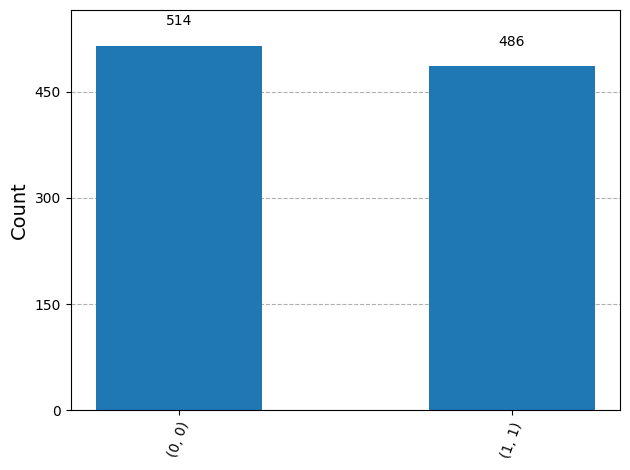

In [8]:
from qiskit.visualization import plot_histogram
counts = result.get_counts()
plot_histogram(counts)

### 1-. `pytket-qiskit`でIBMが提供しているローカルシミュレータで計算

1-1.で作成したベル状態のTKET量子回路があれば、IBMシミュレータのバックエンドを用意すればすぐに量子計算が可能

#### Aerバックエンドの準備

In [9]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

量子シミュレータで利用されているゲートセットで回路を書き換えなければならないがAerシミュレータは多くの量子ゲートをサポートしているので、ここではコンパイルを省略する。  
(エラーが出るようであれば下記の#を外してコンパイルをする。)

In [10]:
#ibm_bell = quantinuum_backend.get_compiled_circuit(bell)

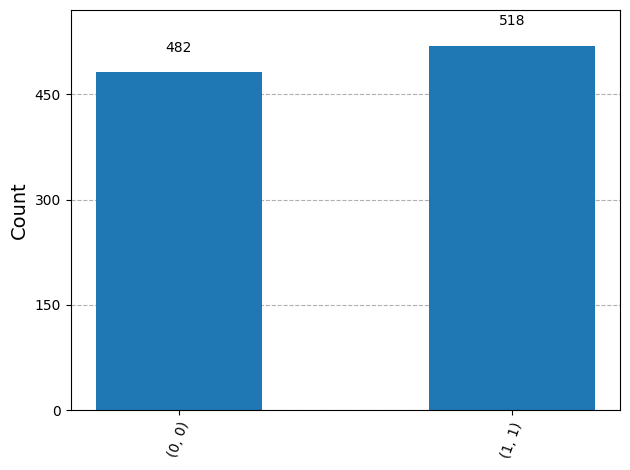

In [11]:
handle = backend.process_circuit(bell, n_shots =1000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

### 1-3. `pytket-qiskit`でTKET 量子回路をIBMの量子デバイスで計算することも可能

#### IBM tokenの設定  
フォルダ内のibm-tokenファイルにtokenの情報を記載して保存してください。

In [12]:
path = 'ibm-token'
f = open(path)
ibm_token = f.read()
f.close()
#from pytket.extensions.qiskit.backends.config import set_ibmq_config
#set_ibmq_config(ibmq_api_token=ibm_token, instance=f"ibm-q/open/main")

In [13]:
from pytket.extensions.qiskit import IBMQBackend
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [14]:
#利用可能なデバイスの確認
device = IBMQBackend.available_devices()

In [16]:
[dev.device_name for dev in device]

In [17]:
# ibm_backend = AerBackend()
ibm_backend = IBMQBackend("ibm_brisbane")

#### IBMの量子デバイス（ibm_brisbane）にジョブを実行
IBM Quantum device の情報  
https://quantum.ibm.com/services/resources

#### 量子デバイス利用されているゲートセットで回路を書き換えなければならない（コンパイル）。
コンパイル前後の回路を図示して比較

In [18]:
ibm_bell = ibm_backend.get_compiled_circuit(bell)
render_circuit_jupyter(ibm_bell)
render_circuit_jupyter(bell)

#### 指定した量子デバイス上で回路を実行

In [19]:
handle = ibm_backend.process_circuit(ibm_bell, n_shots =10)

#### ジョブの実行状況の確認

In [20]:
ibm_backend.circuit_status(handle)

CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='QUEUED', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)

#### COMPLETEDとなっていれば、下記で実行結果を確認することが可能

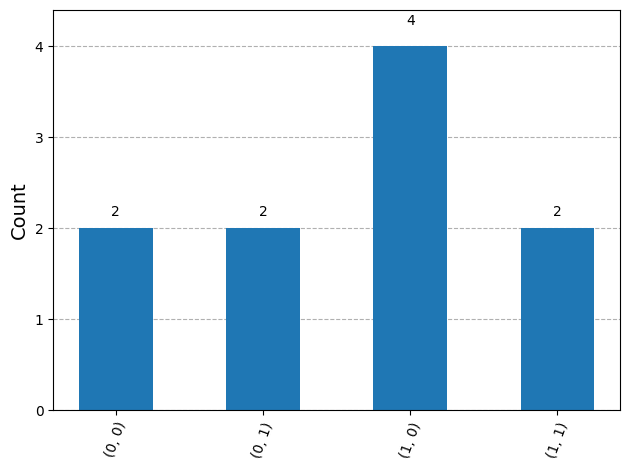

In [21]:
result = ibm_backend.get_result(handle)
counts = result.get_counts()
plot_histogram(counts)

#### `handle`データさえあれば、いつでも以下のようにしてジョブ結果を取り出せる

In [22]:
print(handle)

('d0qygd993rd0008n8100', 0, 2, 'null')


In [23]:
from pytket.backends import ResultHandle
from pytket.extensions.qiskit import IBMQBackend
ibm_backend = IBMQBackend("ibm_brisbane")

Counter({(1, 0): 4, (1, 1): 2, (0, 1): 2, (0, 0): 2})


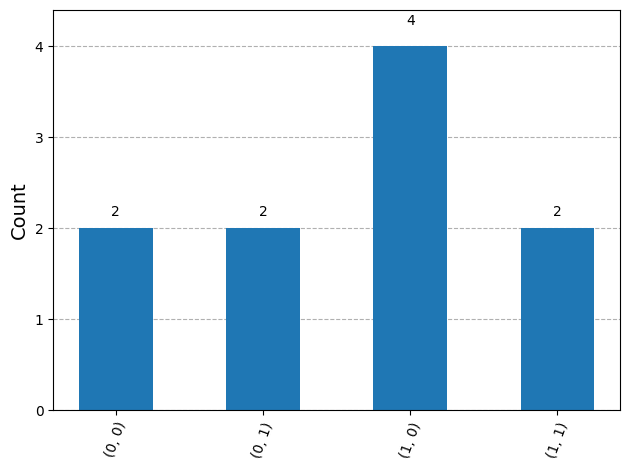

In [24]:
handle_past = ('d0qygd993rd0008n8100', 0, 2, 'null') #右辺に２つ上のセルの結果をペースト
result_past = ibm_backend.get_result(handle_past)
counts_past = result.get_counts()
print(counts_past)
from qiskit.visualization import plot_histogram
plot_histogram(counts_past)

## 2. 量子回路の交換
pytketでは
- qiskitで記述した量子回路(`qiskit.QuantumCircuit`)からtketの量子回路のクラスに変換が可能
- tketで記述した量子回路からqiskitの量子回路(`qiskit.QuantumCircuit`)のクラスに変換が可能
- tketで記述した量子回路と他の量子プログラミング言語での量子回路の交換が可能

参照：[pytket-extensions](https://cqcl.github.io/pytket-extensions/api/index.html) 

### 2-1. `qiskit`の量子回路から`tket`の量子回路に変換

In [25]:
from pytket.extensions.qiskit import qiskit_to_tk

1.1で作成したベル状態をqiskitで作成

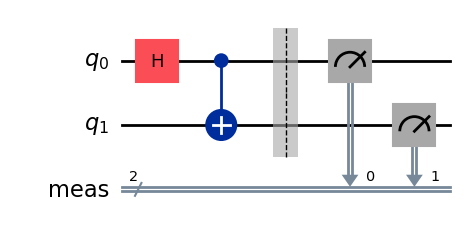

In [26]:
from qiskit import QuantumCircuit
qs_bell = QuantumCircuit(2)
qs_bell.h(0)
qs_bell.cx(0,1)
qs_bell.measure_all()
qs_bell.draw(output='mpl')

qiskitのベル状態量子回路をTKET量子回路に変換

In [27]:
bell2 = qiskit_to_tk(qs_bell)
bell2

[H q[0]; CX q[0], q[1]; Barrier q[0], q[1]; Measure q[0] --> meas[0]; Measure q[1] --> meas[1]; ]

In [28]:
render_circuit_jupyter(bell2)

### 2-2. `tket`の量子回路から`qiskit`の量子回路に変換

In [29]:
from pytket.extensions.qiskit import tk_to_qiskit

1.1で作成したTKETのベル状態量子回路をqsikit量子回路に変換

In [30]:
qs_bell2 = tk_to_qiskit(bell)
qs_bell2

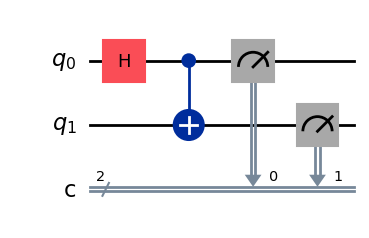

In [31]:
qs_bell2.draw('mpl')

## 3. 量子回路の最適化 Part1
例えば、Hゲートを同じビットに連続して作用させるとゲート操作をしていないのと恒等な量子状態が得られます。
<img src="fig/circ.png" width="500">

量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなるNISQ デバイスでは左辺のような状況は除去したい。

その他にも下記のような恒等な関係があります。
<img src="fig/relation.png" width="700">

### 3-1. PauliSimp 関数を利用した、量子回路の最適化
tketには量子回路を最適化する様々な機能が用意されている。
ここでは、PauliSimp 関数を利用した回路の最適化を行う。

（PauliSimp 関数：Pauli ゲートとCliffordゲートで表現された量子回路を出力）

ランダムな量子回路を作成し、回路の深さとCXの深さを数える。

In [32]:
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox, fresh_symbol, OpType
from pytket.passes import DecomposeBoxes
box = PauliExpBox([Pauli.I, Pauli.Z, Pauli.X, Pauli.Y], fresh_symbol('tm'))
from pytket.utils import Graph
import numpy as np

def get_random_pauli_gadgets(n_qubits, n_pauli_gadgets, max_entangle):
    """ """
    paulis = [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z]
    circ = Circuit(n_qubits)
    for i in range(n_pauli_gadgets):
        ls_paulis = [np.random.choice(paulis) for k in range(max_entangle)]
        if ls_paulis.count(Pauli.Y) % 2 == 0:
            continue
        if len(ls_paulis) - ls_paulis.count(Pauli.I) <= 1:
            continue
        qubits = np.random.choice(
            [i for i in range(n_qubits)], size=max_entangle, replace=False
        )
        box = PauliExpBox(ls_paulis, fresh_symbol('a'))
        circ.add_pauliexpbox(box, sorted(qubits))
    DecomposeBoxes().apply(circ)
    return circ

circ = get_random_pauli_gadgets(
    n_qubits=8, n_pauli_gadgets=300, max_entangle=5
)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)

Circuit depth:  908
CX depth:  571


PauliSimp 関数を使って、量子回路の最適化

In [33]:
# Circuit optimization by using compiler passes.
from pytket.passes import PauliSimp
circx = circ.copy()
PauliSimp().apply(circx)
print('Circuit depth: ', circx.depth())
print('CX depth: ', circx.depth_by_type(OpType.CX))
#render_circuit_jupyter(circx)

Circuit depth:  877
CX depth:  545
